# Continuation method step by step

In this example we step through the continuation method step by step - starting from an axisymmetric vacuum configuration, adding 3D shaping, and then adding pressure.

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../../"))
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 20})

If you have access to a GPU, uncomment the following two lines before any DESC or JAX related imports. You should see about an order of magnitude speed improvement with only these two lines of code!

In [ ]:
# from desc import set_device
# set_device("gpu")

As mentioned in [DESC Documentation on performance tips](https://desc-docs.readthedocs.io/en/latest/performance_tips.html), one can use compilation cache directory to reduce the compilation overhead time. Note: One needs to create `jax-caches` folder manually.

In [3]:
# import jax

# jax.config.update("jax_compilation_cache_dir", "../jax-caches")
# jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
# jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

In [4]:
%matplotlib inline
import numpy as np

from desc.equilibrium import Equilibrium
from desc.geometry import FourierRZToroidalSurface
from desc.objectives import (
    ObjectiveFunction,
    ForceBalance,
    get_fixed_boundary_constraints,
)
from desc.optimize import Optimizer
from desc.plotting import plot_1d, plot_section, plot_surfaces
from desc.profiles import PowerSeriesProfile

## 2D Equilibrium

We start by creating the surface object that represents the axisymmetric boundary.

In [5]:
surface_2D = FourierRZToroidalSurface(
    R_lmn=np.array([10, -1]),  # boundary coefficients
    Z_lmn=np.array([1]),
    modes_R=np.array([[0, 0], [1, 0]]),  # [M, N] boundary Fourier modes
    modes_Z=np.array([[-1, 0]]),
    NFP=5,  # number of (toroidal) field periods (does not matter for 2D, but will for 3D solution)
)

Now we can initialize an Equilibrium with this boundary surface. By default, `Equilibrium` objects have pressure and net toroidal current profiles of `0` assigned. We also increase the resolution and use a collocation grid that oversamples by a factor of two. 

In [6]:
# axisymmetric & stellarator symmetric equilibrium
eq = Equilibrium(surface=surface_2D, sym=True)
eq.change_resolution(L=6, M=6, L_grid=12, M_grid=12)

Next we create our objective function, `ForceBalance` which will seek to make $\mathbf{F} \equiv \mathbf{J} \times \mathbf{B} - \nabla p = 0$

In [7]:
objective = ObjectiveFunction(ForceBalance(eq=eq))

Next we need to specify the optimization constraints, which indicate what parameters that will remain fixed during the optimization process. For this fixed-boundary problem we can call the utility function `get_fixed_boundary_constraints` that returns a list of the desired constraints.

In [8]:
constraints = get_fixed_boundary_constraints(eq=eq)
for c in constraints:
    print(c)

Finally, we can solve the equilibrium with the objective and constraints specified above. We also chose an optimization algorithm by initializing an `Optimizer` object. The `verbose=3` option will display output at each optimization step. 

In [9]:
# this is a port of scipy's trust region least squares algorithm but using JAX functions for better performance
optimizer = Optimizer("lsq-exact")
eq, solver_outputs = eq.solve(
    objective=objective, constraints=constraints, optimizer=optimizer, verbose=3
)

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 1.16 sec
Timer: Objective build = 1.60 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed sheet current
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Timer: Objective build = 463 ms
Timer: LinearConstraintProjection build = 4.18 sec
Number of parameters: 27
Number of objectives: 98
Timer: Initializing the optimization = 6.31 sec

Starting optimization
Using method: lsq-exact
Solver options:
------------------------------------------------------------
Maximum Function Evaluations       : 501
Maximum Allowed Total Δx Norm      : inf
Scaled Termination                 : True
Trust Region Method                : qr
Initial Trust

We can analyze the equilibrium solution using the available plotting routines. . Here we plot the magnitude of the total current density $|\mathbf{J}|$ and the normalized force balance error. We expect both quantities to be low for this vacuum solution. 

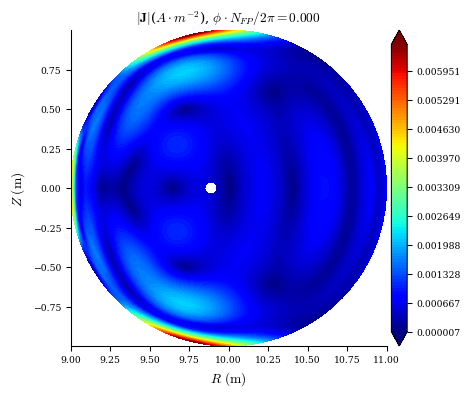

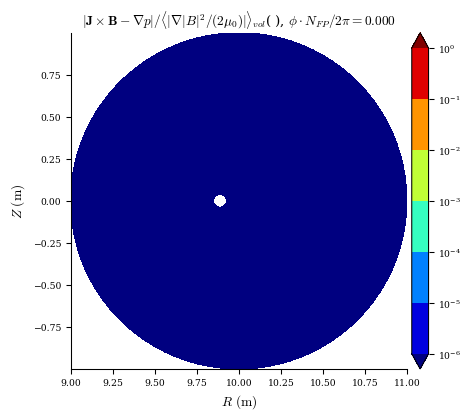

In [10]:
plot_section(eq, "|J|")
plot_section(eq, "|F|_normalized", log=True);

Since this is an axisymmetric vacuum equilibrium, there should be no pressure or rotational transform. We can plot both quantities as follows: 

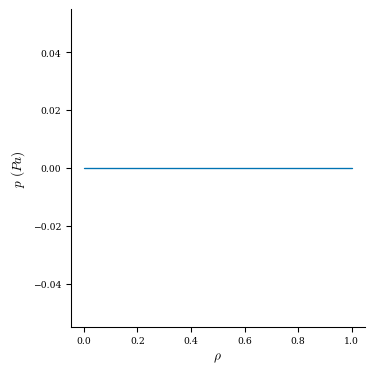

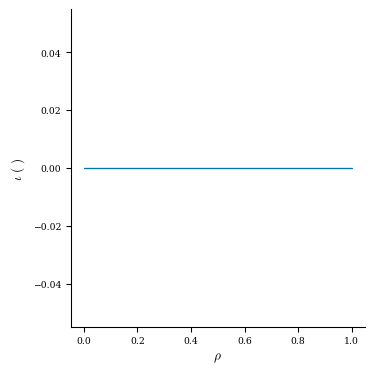

In [11]:
plot_1d(eq, "p")
plot_1d(eq, "iota");

## 3D Equilibrium

Now we want to solve a stellarator vacuum equilibrium by perturbing the existing tokamak solution we already found. We start by creating a new surface to represent the 3D (non-axisymmetric) stellarator boundary. 

In [12]:
surface_3D = FourierRZToroidalSurface(
    R_lmn=np.array([10, -1, -0.3, 0.3]),  # boundary coefficients
    Z_lmn=np.array([1, -0.3, -0.3]),
    modes_R=np.array(
        [[0, 0], [1, 0], [1, 1], [-1, -1]]
    ),  # [M, N] boundary Fourier modes
    modes_Z=np.array([[-1, 0], [-1, 1], [1, -1]]),
    NFP=5,  # number of (toroidal) field periods
)

In the previous solution we did not use any toroidal Fourier modes because they were unnecessary for axisymmetry. Now we need to increase the toroidal resolution, and we will also increase the radial and poloidal resolutions as well. Again we oversample the collocation grid by a factor of two. 

We will also update the resolution of the 3D surface to match the new resolution of the Equilibrium. 

In [13]:
eq.change_resolution(L=10, M=10, N=6, L_grid=20, M_grid=20, N_grid=12)
surface_3D.change_resolution(eq.L, eq.M, eq.N)

We need to initialize new instances of the `objective` and `constraints`. This is necessary because the original instances got built for a specific resolution during the previous 2D equilibrium solve, and are no longer compatible with the Equilibrium after increasing the resolution. 

In [14]:
objective = ObjectiveFunction(ForceBalance(eq=eq))
constraints = get_fixed_boundary_constraints(eq=eq)

Next is the boundary perturbation. In this step, we approximate the heliotron equilibrium solution from a 2nd-order Taylor expansion about the axisymmetric solution. This is possible thanks to the wealth of derivative information provided by automatic differentiation. 

In [15]:
eq.perturb(
    deltas={
        "Rb_lmn": surface_3D.R_lmn - eq.Rb_lmn,  # change in the R boundary coefficients
        "Zb_lmn": surface_3D.Z_lmn - eq.Zb_lmn,  # change in the Z boundary coefficients
    },
    objective=objective,  # perturb the solution such that J=0 is maintained
    constraints=constraints,  # same constraints used in the equilibrium solve
    order=2,  # use a 2nd-order Taylor expansion
    verbose=2,  # display timing data
);

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 871 ms
Timer: Objective build = 1.21 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed sheet current
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Timer: Objective build = 511 ms
Perturbing Rb_lmn, Zb_lmn
Factorizing linear constraints
Timer: linear constraint factorize = 4.45 sec
Computing df
Timer: df computation = 8.34 sec
Factoring df
Timer: df/dx factorization = 756 ms
Computing d^2f
Timer: d^2f computation = 5.14 sec
Timer: Objective build = 1.27 ms
||dx||/||x|| =  3.834e-02
Timer: Total perturbation = 24.3 sec


We now have an approximation of the stellarator equilibrium from the tokamak solution! Let us look at the 3D surfaces and rotational transform profile to check that the perturbation actually updated the solution: 

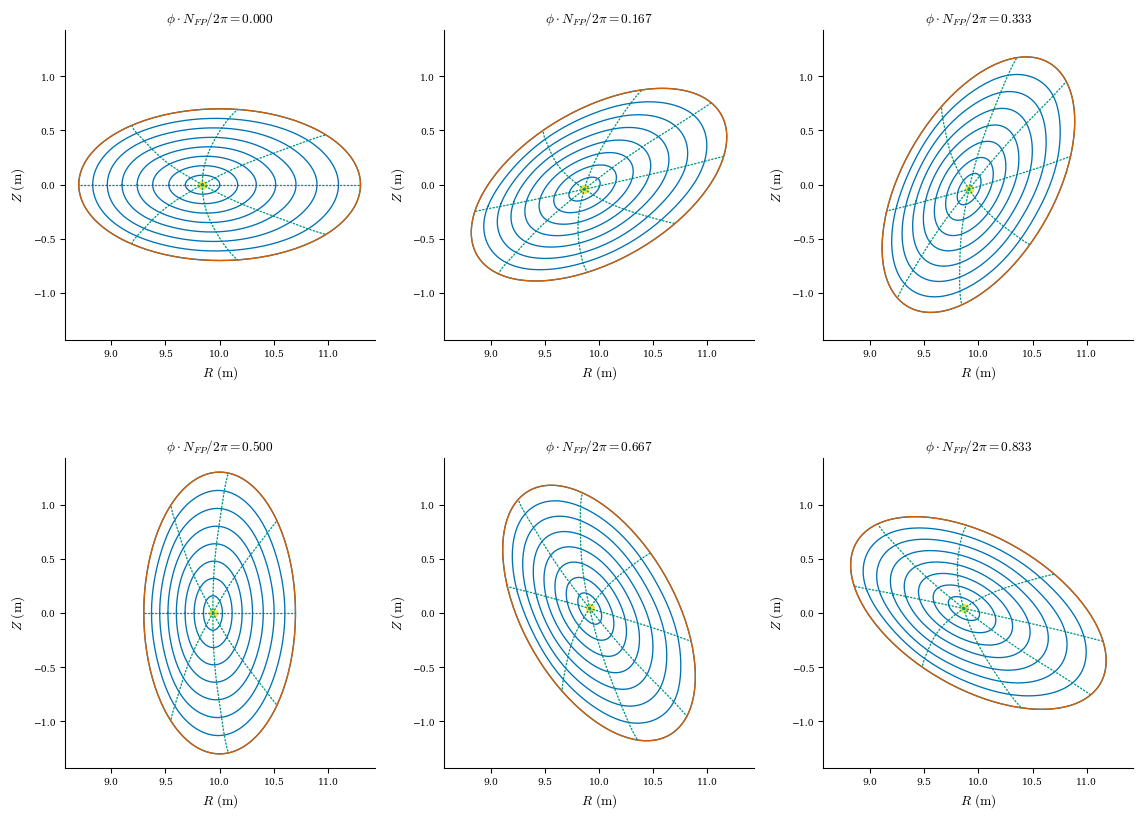

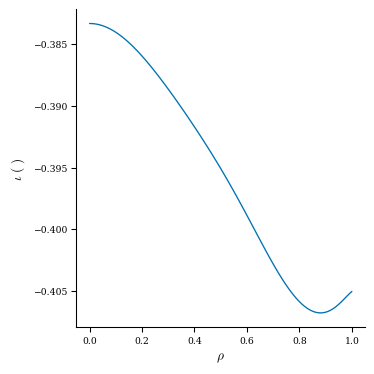

In [16]:
plot_surfaces(eq)
plot_1d(eq, "iota");

The surfaces match the heliotron boundary we want and there is non-zero rotational transform as expected. But the equilibrium error is now large because the perturbed solution is only an approximation to the true equilibrium: 

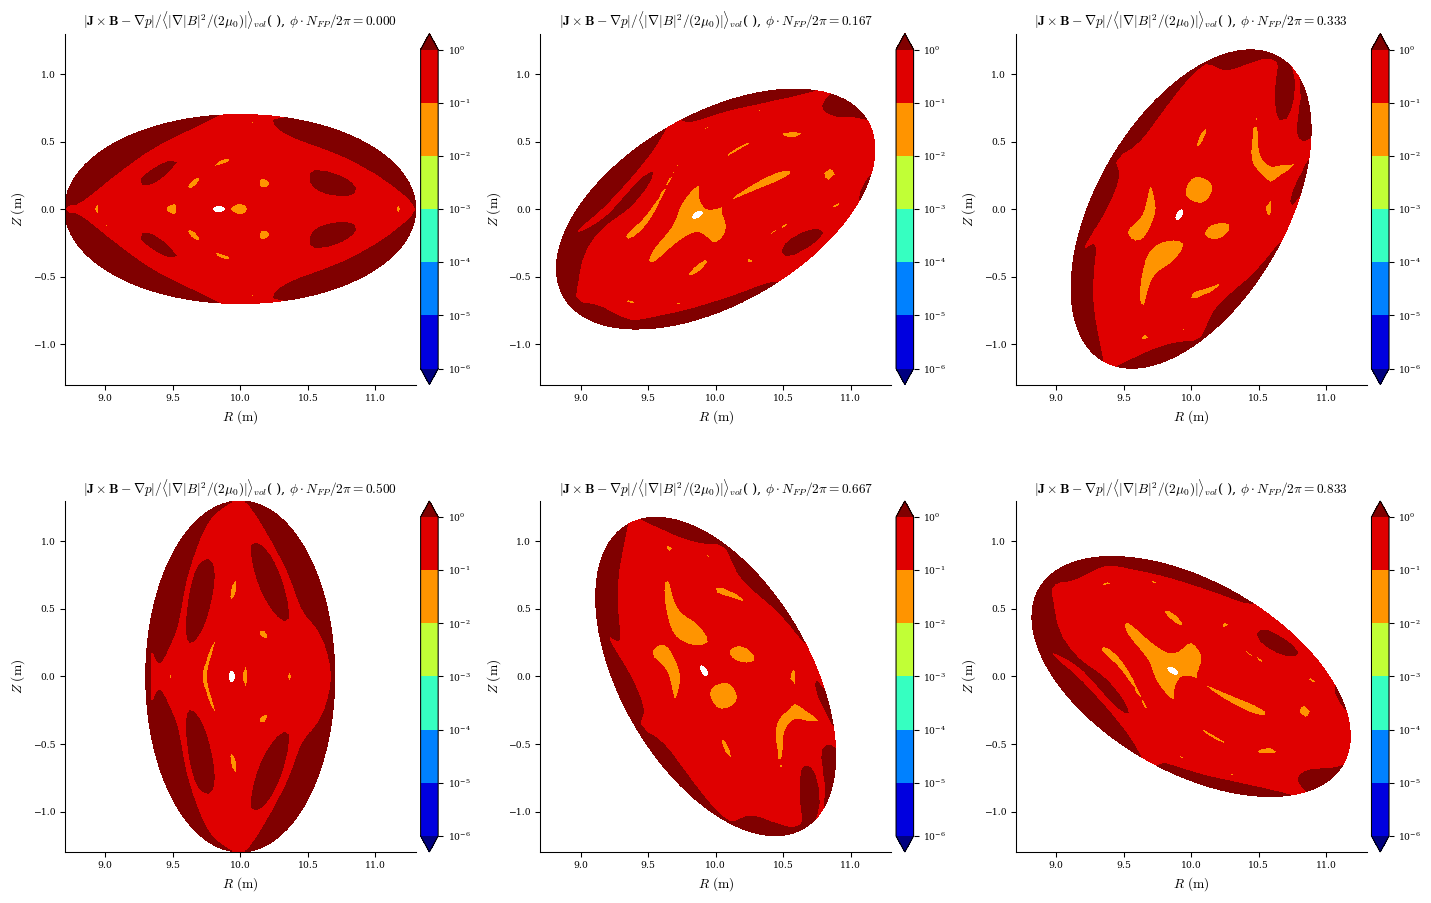

In [17]:
plot_section(eq, "|F|_normalized", log=True);

We can re-solve the equilibrium using the new 3D boundary constraint. This should converge in only a few Newton iterations because we are starting from a good initial guess. 

In [18]:
eq, solver_outputs = eq.solve(
    objective=objective,  # solve JxB-grad(p)=0
    constraints=constraints,  # fixed-boundary constraints
    optimizer=optimizer,  # we can use the same optimizer as before
    ftol=1e-2,  # stopping tolerance on the function value
    xtol=1e-4,  # stopping tolerance on the step size
    gtol=1e-6,  # stopping tolerance on the gradient
    maxiter=20,  # maximum number of iterations
    verbose=3,  # display output at each iteration
)

Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Timer: Objective build = 21.6 ms
Timer: LinearConstraintProjection build = 420 ms
Number of parameters: 1011
Number of objectives: 6050
Timer: Initializing the optimization = 485 ms

Starting optimization
Using method: lsq-exact
Solver options:
------------------------------------------------------------
Maximum Function Evaluations       : 101
Maximum Allowed Total Δx Norm      : inf
Scaled Termination                 : True
Trust Region Method                : qr
Initial Trust Radius               : 9.263e+01
Maximum Trust Radius               : inf
Minimum Trust Radius               : 2.220e-16
Trust Radius Increase Ratio        : 2.000e+00
Trust Radius Decrease Ratio        : 2.500e-01
Trust Radius Increase Threshold    : 7.500e-01
Trust Radius Decrease Threshold    : 2.500e-01
--------

We can analyze our final solution using the same plotting commands as before. Note that the flux surfaces and rotational transform profile only had small corrections compared to the perturbed solution, but the equilibrium error was significantly improved. 

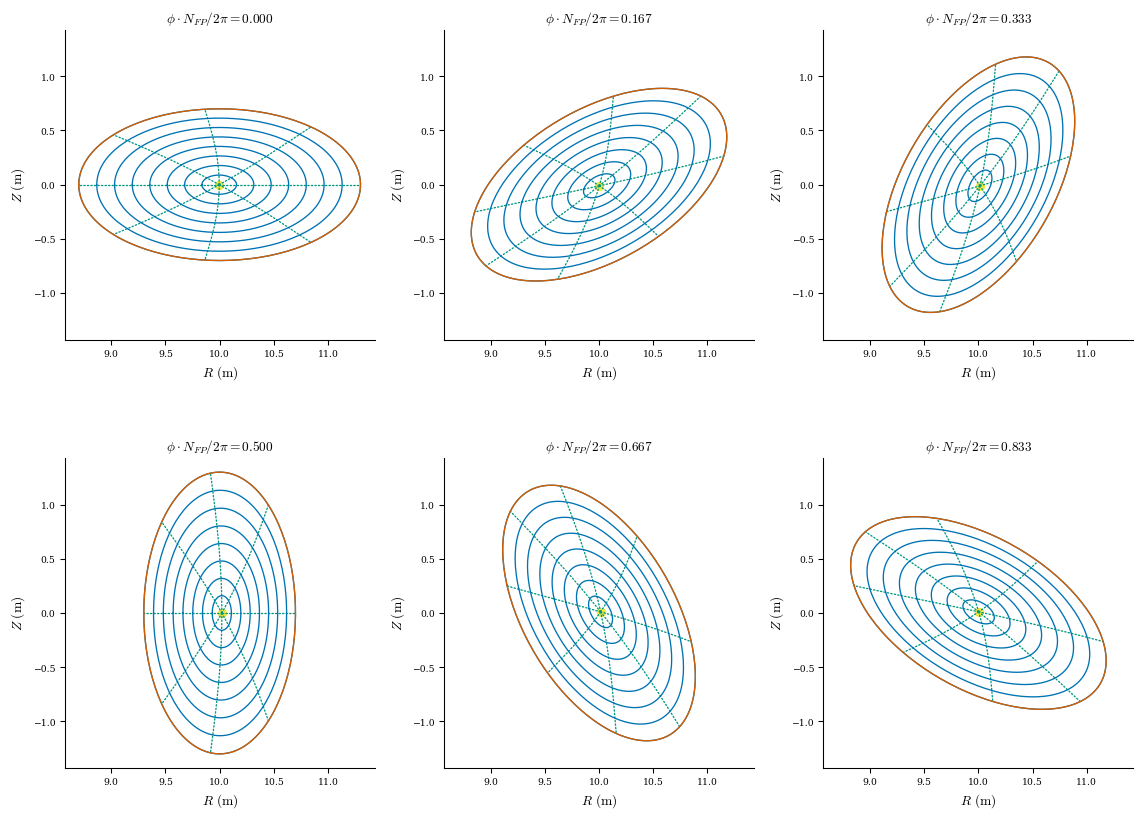

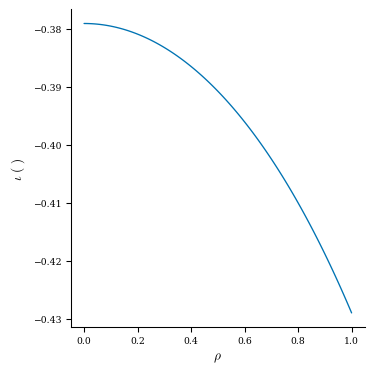

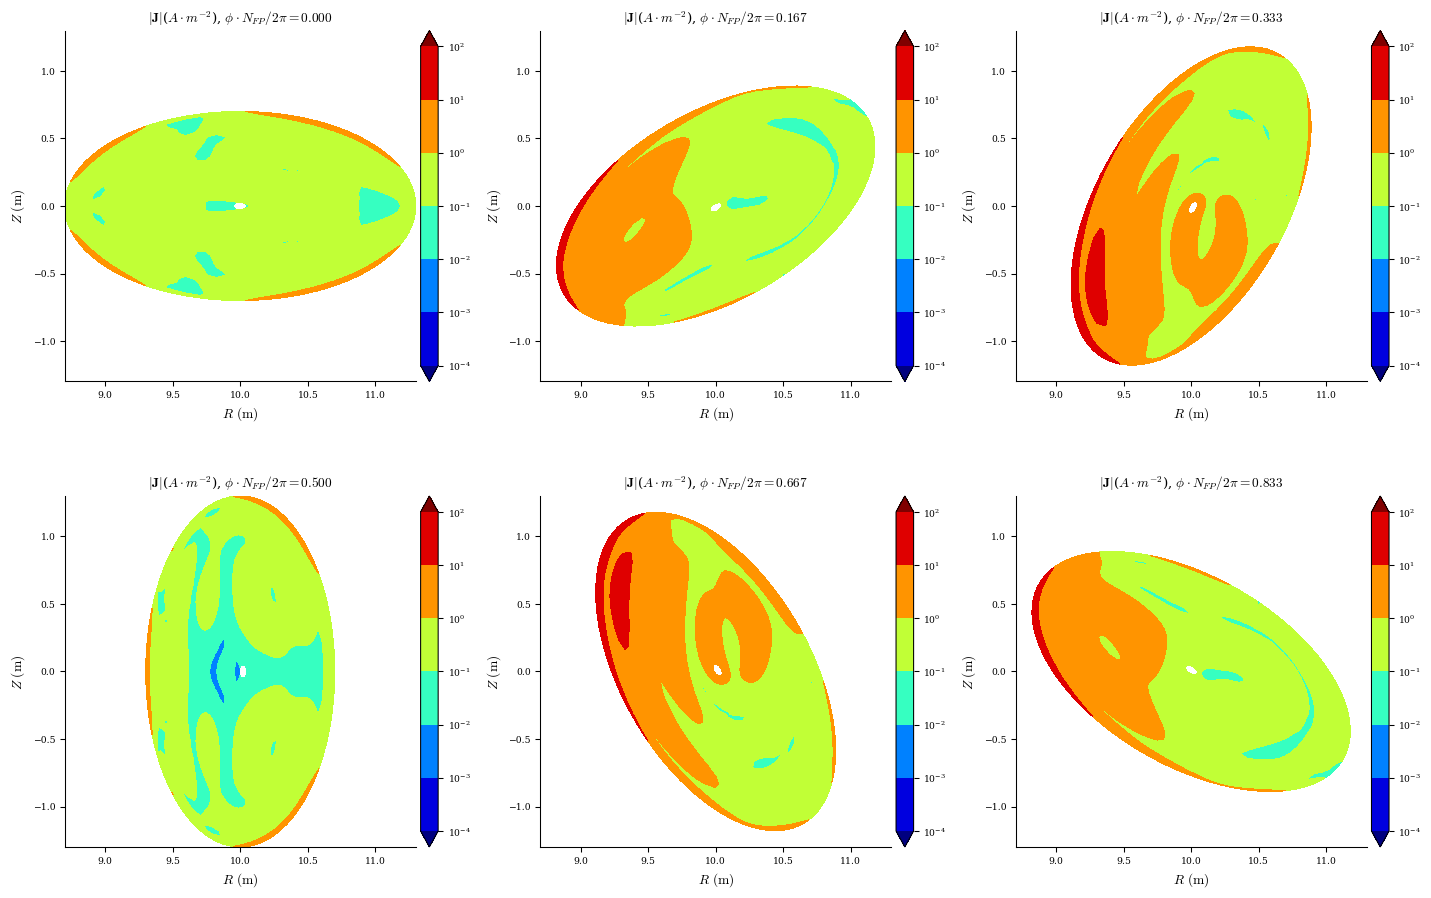

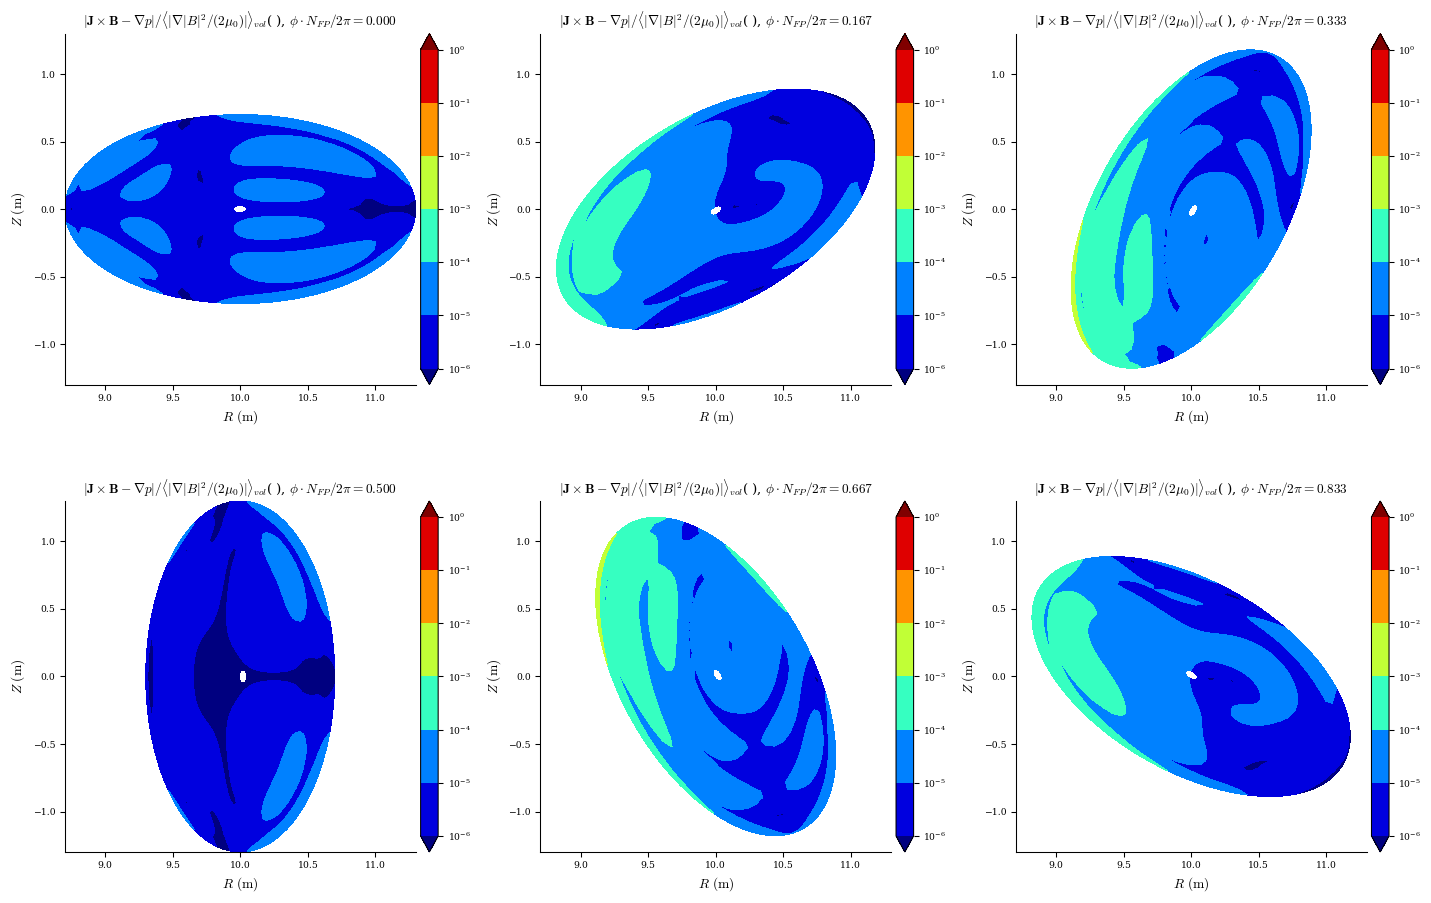

In [19]:
plot_surfaces(eq)
plot_1d(eq, "iota")
plot_section(eq, "|J|", log=True)
plot_section(eq, "|F|_normalized", log=True);

## Finite beta stellarator

We've solved for a vacuum stellarator, but what if we now want to look at what happens at finite beta? We can simply apply a pressure perturbation.


In [20]:
from desc.objectives import ForceBalance

objective = ObjectiveFunction(ForceBalance(eq=eq))
constraints = get_fixed_boundary_constraints(eq=eq, profiles=True)

Next we'll make our desired pressure profile, corresponding to a profile of the form $p(\rho) = 2000(1 - 2 \rho^2 + \rho^4) ~\text{Pa}$

In [21]:
from desc.profiles import PowerSeriesProfile

pressure = PowerSeriesProfile([2000, 0, -4000, 0, 2000])
pressure.change_resolution(eq.L)

Now, we will perturb our equilibrium's pressure coefficients $p_l$ to match those of the target pressure

In [22]:
eq.perturb(
    deltas={"p_l": pressure.params - eq.p_l},  # change in the pressure coefficients
    objective=objective,  # perturb the solution such that JxB-grad(p)=0 is maintained
    constraints=constraints,  # same constraints used in the equilibrium solve
    order=2,  # use a 2nd-order Taylor expansion
    verbose=2,  # display timing data
);

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 65.2 ms
Timer: Objective build = 84.3 ms
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed sheet current
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Timer: Objective build = 221 ms
Perturbing p_l
Factorizing linear constraints
Timer: linear constraint factorize = 312 ms
Computing df
Timer: df computation = 18.6 ms
Factoring df
Timer: df/dx factorization = 781 ms
Computing d^2f
Timer: d^2f computation = 7.07 ms
Timer: Objective build = 1.09 ms
||dx||/||x|| =  6.321e-02
Timer: Total perturbation = 2.90 sec


We can see that the axis has moved due to the Shafranov shift, and the pressure profile is now nonzero. The force balance error is significantly larger, however.

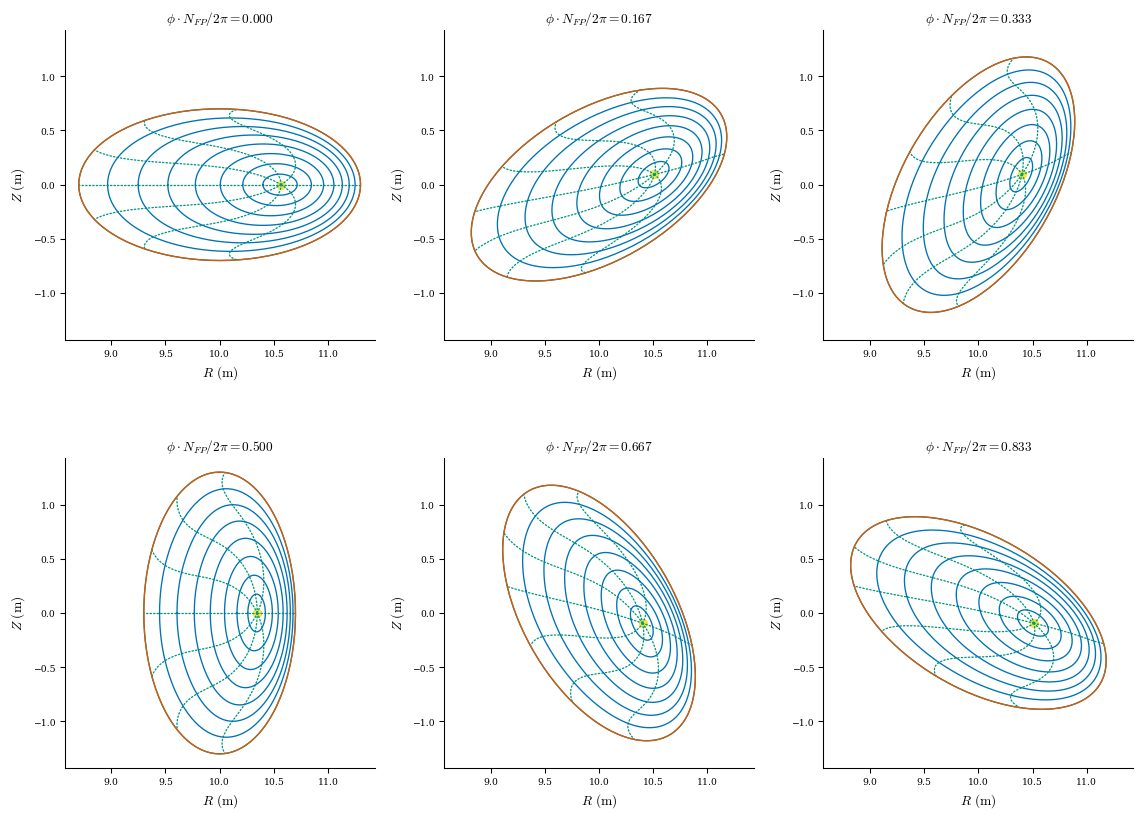

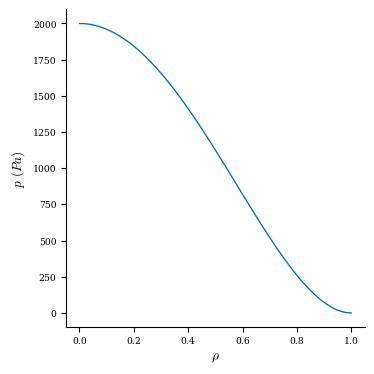

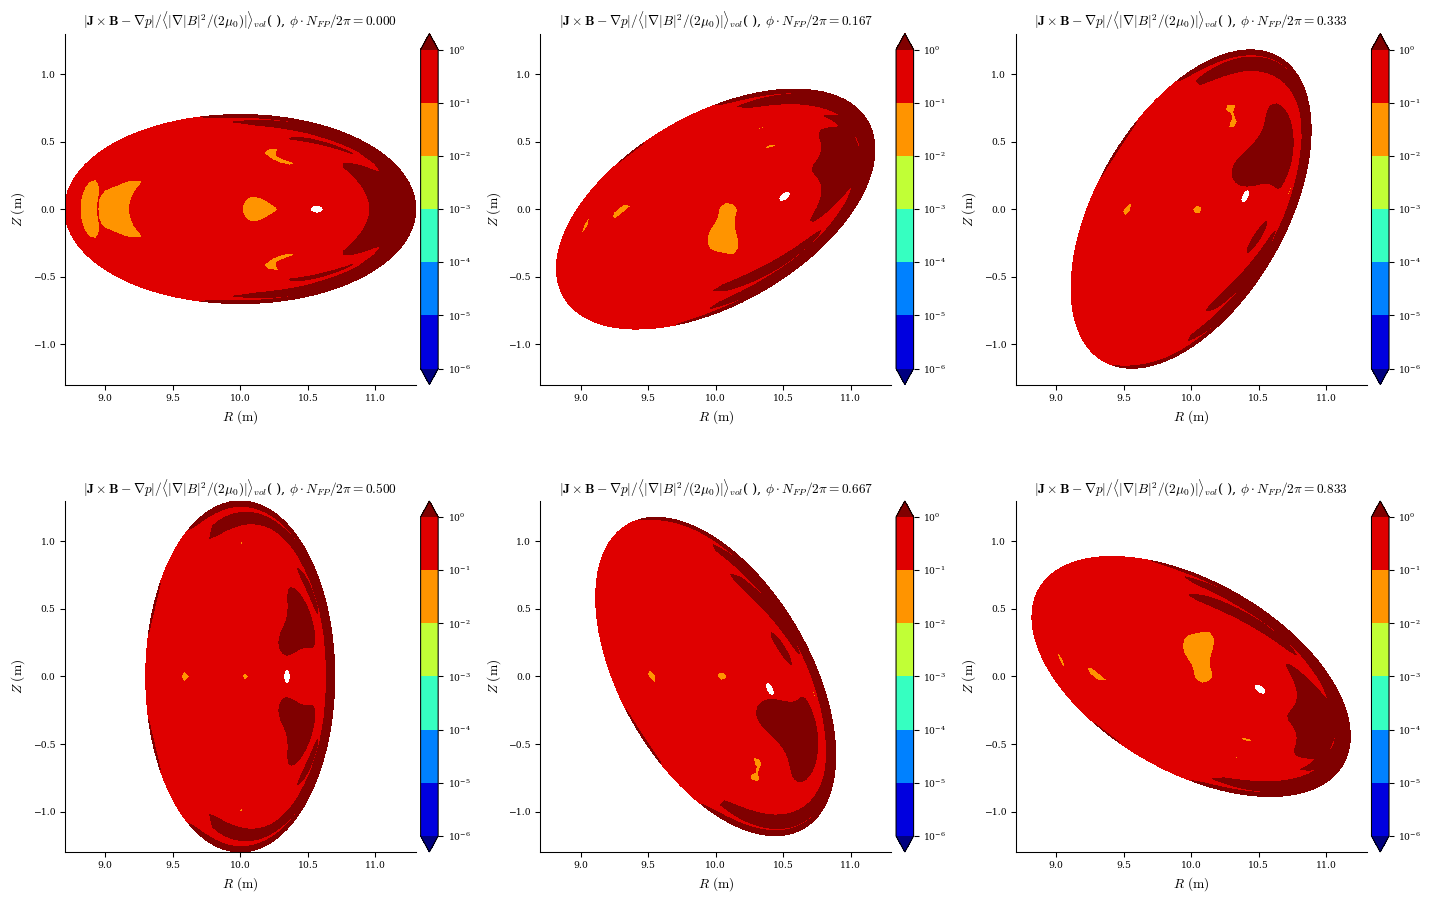

In [23]:
plot_surfaces(eq)
plot_1d(eq, "p")
plot_section(eq, "|F|_normalized", log=True);

In [24]:
eq, solver_outputs = eq.solve(
    objective=objective,  # solve JxB-grad(p)=0
    constraints=constraints,  # fixed-boundary and profile constraints
    optimizer=optimizer,  # we can use the same optimizer as before
    ftol=1e-2,  # stopping tolerance on the function value
    xtol=1e-4,  # stopping tolerance on the step size
    gtol=1e-6,  # stopping tolerance on the gradient
    maxiter=75,  # maximum number of iterations
    verbose=3,  # display output at each iteration
)

Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Timer: Objective build = 18.4 ms
Timer: LinearConstraintProjection build = 226 ms
Number of parameters: 1011
Number of objectives: 6050
Timer: Initializing the optimization = 294 ms

Starting optimization
Using method: lsq-exact
Solver options:
------------------------------------------------------------
Maximum Function Evaluations       : 376
Maximum Allowed Total Δx Norm      : inf
Scaled Termination                 : True
Trust Region Method                : qr
Initial Trust Radius               : 1.928e+02
Maximum Trust Radius               : inf
Minimum Trust Radius               : 2.220e-16
Trust Radius Increase Ratio        : 2.000e+00
Trust Radius Decrease Ratio        : 2.500e-01
Trust Radius Increase Threshold    : 7.500e-01
Trust Radius Decrease Threshold    : 2.500e-01
--------

After re-solving, we find the force blance residuals are much lower, less than 1\% normalized errors throughout the volume:

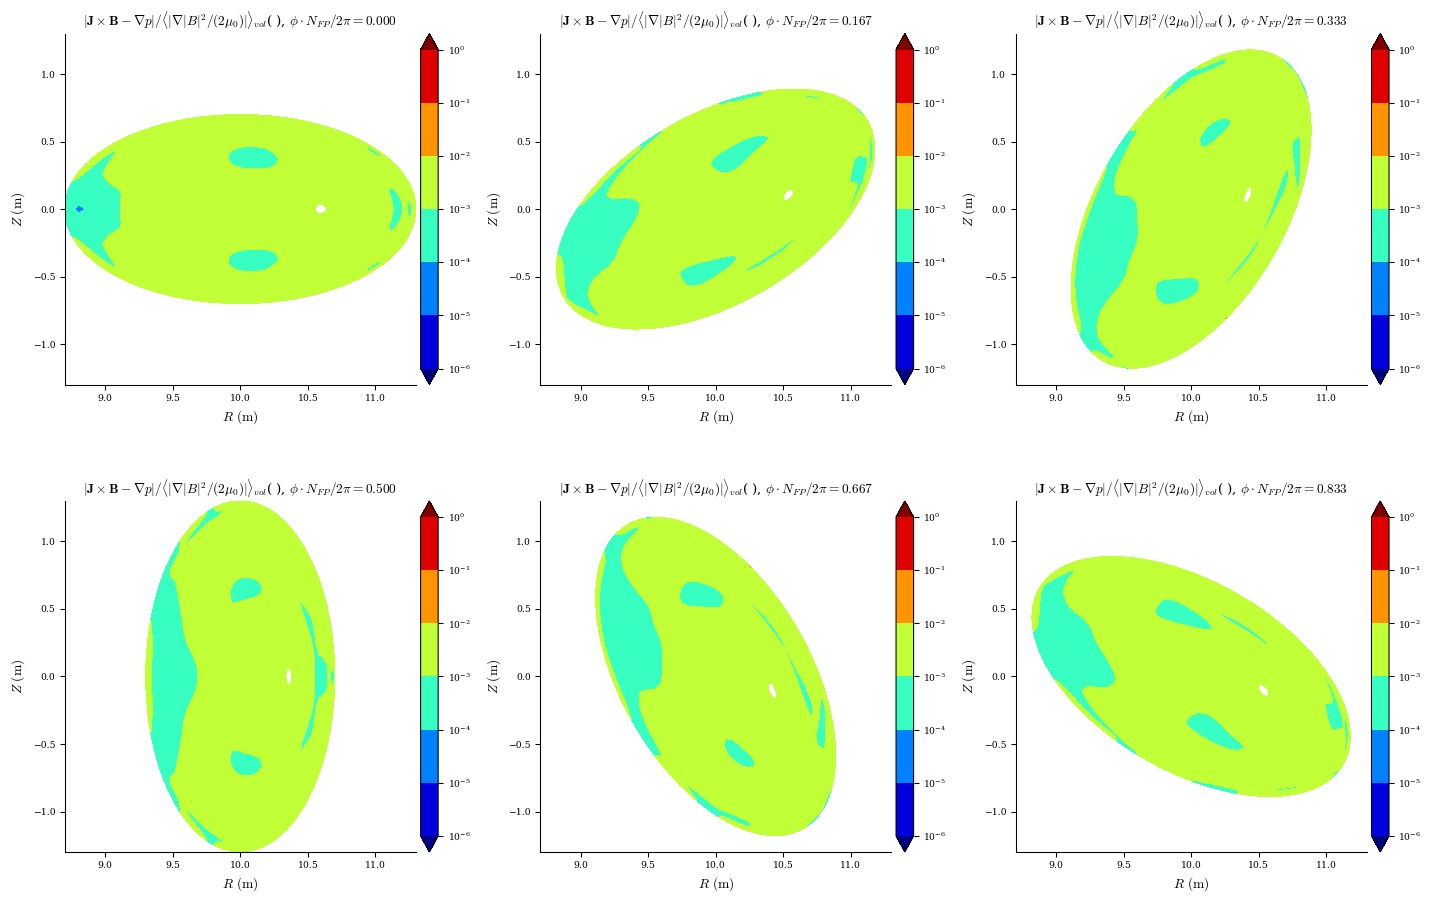

In [25]:
plot_section(eq, "|F|_normalized", log=True);